# Descarga de submissions de Reddit mediante el modulo Pushshift usando Python

Para descarga de información en Reddit contamos con muchas herramientas como PRAW, PMAW y requests.

PMAW es derivado de PRAW y ambos tienen algunas limitantes, como la eliminación del   *subreddit.submissions* que nos permite seleccionar la información que será descargada.

Es por esto que se opta por utilizar  *requests* para acceder a Reddit y obtener la información almacenada en **Pushshift**.



# Importar módulos

In [1]:
import pandas as pd # Uso de dataframes
import requests # Método para acceder a Pushshift por mediante url 
import json # Manipulación de información JSON
import csv # Para convertir las tablas finales en archivos csv y guardarla en la máquina local
import time # Convertir el tiempo UTC en tiempo GMT
import datetime # Manipulación del tiempo
from google.colab import drive
drive.mount('/content/drive')
location = "/content/drive/MyDrive/Pushshift/"

Mounted at /content/drive


# Ejemplos de URLS de Pushshift

In [2]:
# Se puede acceder al API de Pushshift a través de una URL con los parámetros relevantes sin necesidad de identificarse en Reddit
# Estos son algunos ejemplos de URLs que generan una página con información JSON
busca_gaming_despues_fecha = "https://api.pushshift.io/reddit/search/submission/?q=screenshot&after=1514764800&before=1517443200&subreddit=gaming"
busca_science = "https://api.pushshift.io/reddit/search/submission/?q=science"

# Parámetros para el URL de Pushshift
Estos son los parámetros que se conideran más importantes para la consulta de Reddit, utilizados para la construcción del URL de Pushshift:

* size — Tamaño de entradas devueltas, modificado a 1,000
* after — Dónde comienza la búsqueda 
* before — Dónde finaliza la búsqueda
* title — Busca submissions que contengan la palabra en el título
* subreddit — Busca en un Subreddit en particular

Todo esto con la finalidad de reducir el tamaño de la búsqueda.

In [ ]:
# Adaptado de https://gist.github.com/dylankilkenny/3dbf6123527260165f8c5c3bc3ee331b
# Se construye la URL de Pushshift, accediendo a una pagina web donde está almacenada la información en JSON a manera de lista
def getPushshiftData(query, after, before, sub):
    # Construye la URL de Pushshift con los parámetros antes mencionados
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    # Muestra al usuario la URL 
    print(url)
    # Solicitud de la URL
    r = requests.get(url, headers = {'User-agent': 'bot_1'})
    r.raise_for_status()
    # Carga la pagina con la información JSON en una variable
    if r.status_code != 204:
      data = json.loads(r.text, strict=False,encoding='utf-8')
    #regresa la información de la variable donde está contenida
    return data['data']

# Extrae la información clave de Submissions

Es aquí donde tenemos la libertad de solicitar la información que requerimos de Submissions para nuestro análisis: 
* Title: Título de la noticia
* URL: URL de la noticia
* Subreddit: Grupo en el que se publicó el submission
* Selftext: Contenido de la noticia, no todas las noticiac cuentan con esto
* Flair: Tópico del submission
* Author: Usuario que publicó el submission
* ID: ID para identificar el submission
* Score: Puntuación del submission
* Created_utc: Fecha de publicación
* Num_comments: Número de comentarios 
* Permalink: Enlace permanente.


In [ ]:
# Extracción de la información específica de los datos JSON generados  
# Seleccionar los parámetros deseados de pushshift: https://pushshift.io/api-parameters/
def collectSubData(subm):
    #subData fue creado al inicio donde está toda la información para ser agregados a la variable global subStats.
    subData = list() # lista para almacenar la información
    title = subm['title'] # Titulo 
    url = subm['url'] # URL
    subreddit = subm['subreddit'] # Grupo Subreddit
    # selftext, o cuerpo del post, no siempre está presente en submissions, para evitar errores se usa try/except
    try:
      body = subm['selftext']
    except KeyError:
      body = ''
    #flairs no siempre está presente en submissions, para evitar errores se usa try/except
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"    
    author = subm['author'] # Autor del post
    sub_id = subm['id'] # ID del post
    score = subm['score'] # Puntuación del post
    created = datetime.datetime.fromtimestamp(subm['created_utc']) # Fecha de creación en UTC, por lo que se hace la conversión
    numComms = subm['num_comments'] # Número de comentarios
    permalink = subm['permalink'] # Linl permanente

    #Junta toda la información en una tubla y se agrega a subData
    subData.append((sub_id,title,url,subreddit,body,author,score,created,numComms,permalink,flair))
    # Crea un diccionario con la entrada de información del submission actual y almacena toda la información relacionada con el submission
    subStats[sub_id] = subData

# Actualiza los parámetros de búsqueda

In [ ]:
# Para tener el formato correcto de tiempo de la URL se puede usar la siguiente página
#https://www.unixtimestamp.com/index.php > Esto para crear el propio timestamp
after = "1577836800" #Submissions despues del timestamp 01 Enero 2020 0:00:0 1577836800
before = "1640995200" #Submissions antes del timestamp 01 Enero 2022 0:00:0 1640995200
query = "" # Palabra clave para buscar en submissions
sub = "wallstreetbets" #Cual Subreddit se buscará la información

#subCount cuenta el no. del total de envíos que se recopila
subCount = 0
#subStats es el diccionario donde almacenaremos nuestros datos.
subStats = {}

In [ ]:
# Necesitamos ejecutar esta función fuera del ciclo primero para obtener después la variable actualizada
data = getPushshiftData(query, after, before, sub)
# Se ejecutará hasta que se hayan recopilado todas las publicaciones, es decir, cuando la longitud de la variable de datos = 0
# desde la fecha 'posterior' hasta la fecha 'anterior'
while len(data) > 0: #La longitud de los datos es el número de submission(data[0],data[1], etc.), una vez que llega a cero (después y antes de que vars sean iguales) finaliza
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Llama getPushshiftData() Con la fecha creada del ultimo submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    #actualiza la variable 'after' a la última fecha creada del submission
    after = data[-1]['created_utc']
    # datos han cambiado debido a la nueva variable posterior proporcionada por el código anterior
    data = getPushshiftData(query, after, before, sub)
    
print(len(data))

https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635728400&before=1640995200&subreddit=wallstreetbets
99
2021-11-01 05:50:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635745815&before=1640995200&subreddit=wallstreetbets
100
2021-11-01 11:39:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635766775&before=1640995200&subreddit=wallstreetbets
100
2021-11-01 14:24:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635776691&before=1640995200&subreddit=wallstreetbets
100
2021-11-01 15:51:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635781919&before=1640995200&subreddit=wallstreetbets
100
2021-11-01 17:19:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635787168&before=1640995200&subreddit=wallstreetbets
100
2021-11-01 18:34:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1635791649&befo

# Revisión de que la extracción del submission se haya cumplido con exito

In [ ]:
print(str(len(subStats)) + " submissions agregado a la lista")
print("1st entrada es:")
print(list(subStats.values())[0][0][1] + " creado por: " + str(list(subStats.values())[0][0][5]))
print("Ultima entrada es:")
print(list(subStats.values())[-1][0][1] + " creado por: " + str(list(subStats.values())[-1][0][5]))

48368 submissions agregado a la lista
1st entrada es:
Representing the greatest retards on earth this year creado por: ndawgkrunk69
Ultima entrada es:
Winner or loser? Only time will tell. 2021 ends. The figure below shows the annual return rate of investors who are holding the asset all year without trading. If you have adopted an active trading strategy, but the annual return is lower than the benchmark, think about what went wrong? creado por: jackyan006


# Guardado de información en archivo CSV

In [ ]:
def updateSubs_file(location):
    upload_count = 0
    print("Ingresa el nombre del archivo agregando .csv al final ")
    #location = "/content/drive/MyDrive/Pushshift/Parts/"
    filename = input() #Nombre que puso al archivo csv
    file = location + filename
    with open(file, 'w', newline='', encoding='utf-8') as file: 
        a = csv.writer(file, delimiter=',')
        headers = ["Post ID","Title","Url","Subreddit","Body","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"]
        a.writerow(headers)
        for sub in subStats:
            a.writerow(subStats[sub][0])
            upload_count+=1
            
        print(str(upload_count) + " submissions han sido guardados en un archivo csv")


In [ ]:
updateSubs_file(location+"Parts/")

Ingresa el nombre del archivo agregando .csv al final 
wallstreetbets_2021_11.csv
48368 submissions han sido guardados en un archivo csv


In [ ]:
# Une todos los archivos con terminación .csv en uno solo, esto debido a que se descargó por partes las noticias
import glob
example = []
for infile in glob.glob(location+"Parts/*.csv"):
  data = pd.read_csv(infile)
  example.append(data)
appended_data = pd.concat(example)
file_all = (location+"/WallStreetbets.csv")
appended_data.to_csv(file_all)

# Información de Yahoo Finance

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 2.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
tick="GME"
start='2020-01-01'
end='2022-01-01'

df_y=yf.download(tick,start, end, progress=False)
df_y.head(5)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,6.14,6.47,6.07,6.31,6.31,4453600
2020-01-03,6.21,6.25,5.84,5.88,5.88,3543900
2020-01-06,5.80,5.91,5.60,5.85,5.85,3394800
2020-01-07,5.77,5.83,5.44,5.52,5.52,5228000
2020-01-08,5.49,5.85,5.41,5.72,5.72,5629400


In [ ]:
file_Yaho = (location+"Finance/Yahoo_GME.csv")

df_y.to_csv(file_Yaho)

# Analisis de información


In [2]:
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
data = pd.read_csv(location +"WallStreetbets.csv")
data_y = pd.read_csv(location +"Finance/Yahoo_GME.csv")
del data['Unnamed: 0']

Populating the interactive namespace from numpy and matplotlib


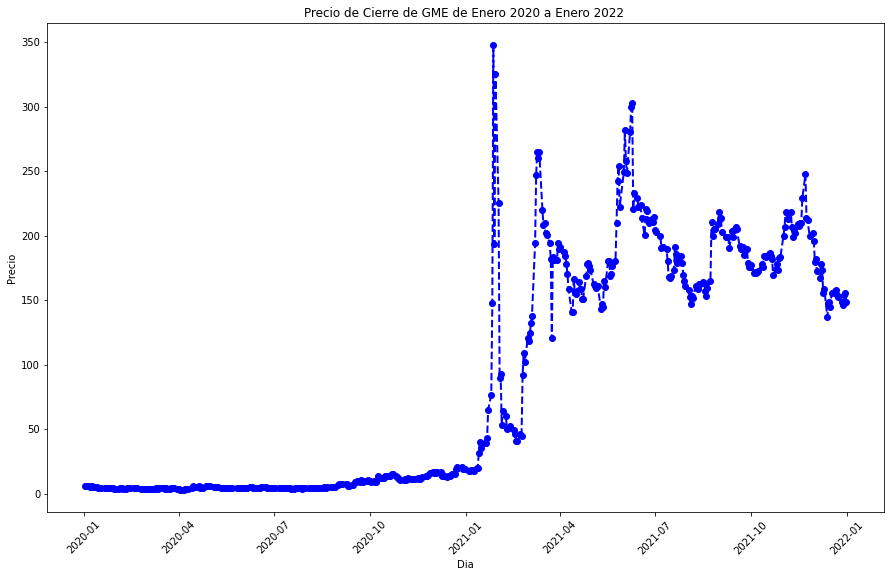

In [4]:
%pylab inline
 
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

x = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in data_y["Date"]]
y = data_y["Adj Close"]

plt.title("Precio de Cierre de GME de Enero 2020 a Enero 2022 ")
plt.xlabel("Dia")
plt.xticks(rotation=45)
plt.ylabel("Precio")
plt.plot_date(x,y,c="blue",ls="--" ,lw=2)
plt.show()

El gráfico de velas nos ayuda a describir el movimiento de precios de la compañía, el color de la vela representa el movimiento, el rojo es un precio de cierre mas bajo que el de apertura y una verde es un precio de cierre mas alto que el de apertura. La longuitud representa el rango de precios que se mueve en el día.

In [26]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data_y['Date'],
                open=data_y['Open'],
                high=data_y['High'],
                low=data_y['Low'],
                close=data_y['Close'])])

fig.show()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486198 entries, 0 to 1486197
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Post ID                1486198 non-null  object
 1   Title                  1486197 non-null  object
 2   Url                    1486198 non-null  object
 3   Subreddit              1486198 non-null  object
 4   Body                   835033 non-null   object
 5   Author                 1486198 non-null  object
 6   Score                  1486198 non-null  int64 
 7   Publish Date           1486198 non-null  object
 8   Total No. of Comments  1486198 non-null  int64 
 9   Permalink              1486198 non-null  object
 10  Flair                  1440631 non-null  object
dtypes: int64(2), object(9)
memory usage: 124.7+ MB


In [ ]:
 835033/1486198 # Postcon cuerpo 

0.5618585141414536

In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,1486198.0,20.316668,768.236567,0.0,1.0,1.0,1.0,134840.0
Total No. of Comments,1486198.0,28.958890,929.586307,0.0,0.0,0.0,2.0,204825.0


El usuario que aparece como "[deleted]" puede deberse a que el usuario borró el post, aunque el post permanece almacenado el registro del usuario permanece.
También se puede deber a que el usuario eliminó su cuenta, por lo que todos los comentarios y posts que realizó permanecen, pero no el nombre del usuario

In [8]:
authors_count = data[['Title','Author']].groupby('Author').count() 
#Put them in order from highest to lowest
authors_count = authors_count.sort_values(by='Title', ascending=False)
authors_count.head(10)

,Title
Author,
[deleted],88853
Onboarding92,1106
WSBVoteBot,1099
OPINION_IS_UNPOPULAR,597
AutoModerator,573
Janto_2021,291
patrickbateman02,282
1poundbookingfee,274
pdwp90,266


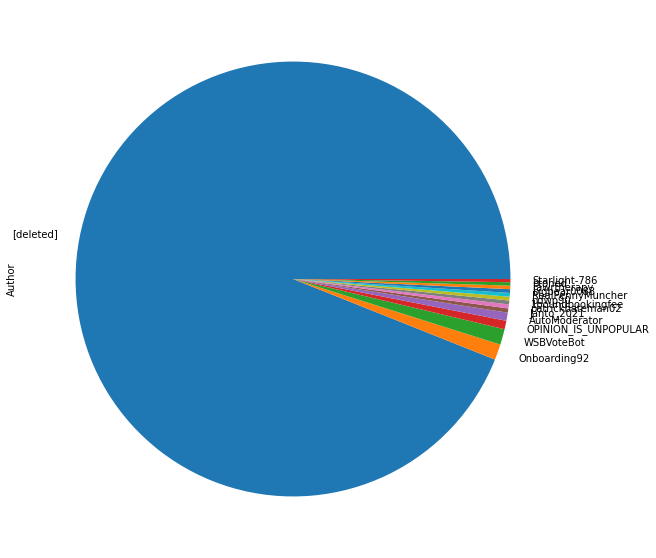

In [14]:
%matplotlib inline
sub_aut = data['Author'].value_counts()
sub_aut = sub_aut[sub_aut >= 200]
sub_aut.plot(kind='pie', figsize=(10,10))

In [ ]:
print(data.groupby(['Title']).size().sort_values())

Title
The Final Nail In The Coffin              1
Rate the robinhood app on play store       1
Rate the rap                               1
Rate the app 1 star                        1
Rate the US economy.                       1
                                        ... 
SNDL                                     822
WSBVoteBot log for May 02 2020           882
Dogecoin                                 982
GME                                     1423
AMC                                     2690
Length: 1314949, dtype: int64


In [ ]:
print(data.groupby(['Publish Date']).size().sort_values())

Publish Date
2020-01-01 00:00:53     1
2021-03-08 16:23:20     1
2021-03-08 16:23:28     1
2021-03-08 16:23:33     1
2021-03-08 16:23:39     1
                       ..
2021-01-28 16:52:05    15
2021-01-28 14:57:53    15
2021-01-28 15:03:59    15
2021-01-28 15:06:49    16
2021-01-28 14:58:25    16
Length: 1188258, dtype: int64


In [5]:
data['Publish Date'] = data['Publish Date'].apply(lambda x: x.split(' ')[0])
#print(data.groupby(['Publish Date']).size().sort_values())
post_count = data[['Publish Date','Title']].groupby('Publish Date').count() 
post_count = post_count.sort_values(by='Title', ascending=False)
post_count.head(10)

,Title
Publish Date,
2021-01-28,164265
2021-01-29,114239
2021-02-01,76069
2021-02-02,71496
2021-01-30,55916
2021-01-31,45717
2021-01-27,43393
2021-02-03,36214
2021-02-04,28186


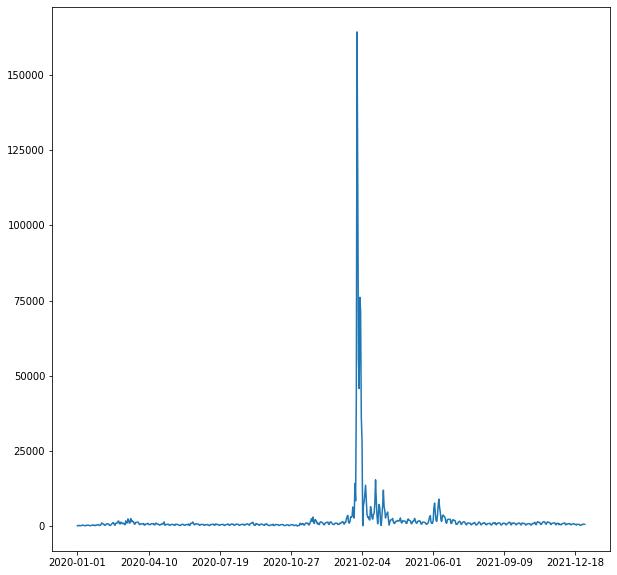

In [5]:
%matplotlib inline
sub_date = data['Publish Date'].value_counts().sort_index()
sub_date.plot(kind='line', figsize=(10,10))

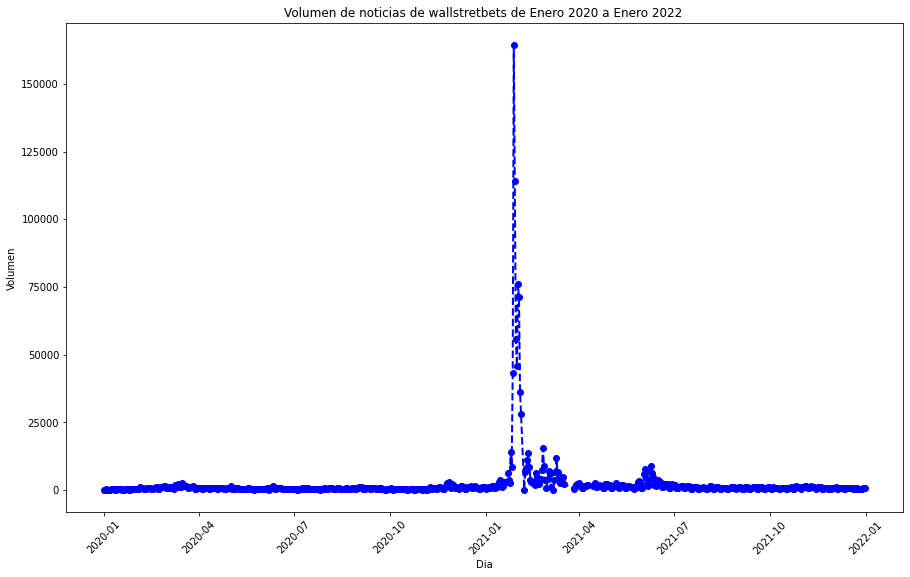

In [6]:
y=data['Publish Date'].unique()
x = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in y]
sub_date = data['Publish Date'].value_counts().sort_index()
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.title("Volumen de noticias de wallstretbets de Enero 2020 a Enero 2022 ")
plt.xlabel("Dia")
plt.xticks(rotation=45)
plt.ylabel("Volumen")
plt.plot_date(x,sub_date,c="blue",ls="--" ,lw=2)
plt.show()

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', '', text)
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop]) #Elimina las stopwords

In [8]:
data['Title']

0            The halving will do nothing for Bitcoin’s price
1                                          New year biatches
2                   Investing is easy bro. Look at my charts
3                                            HAPPY NEW YEAR!
4                                         happy 2020 autists
                                 ...                        
1486193    Winner or loser? Only time will tell. 2021 end...
1486194                                       Stock Exchange
1486195                 Solid first year on the stock market
1486196    Fireworks outside Ryan Kagy’s virtual room! Ge...
1486197    Winner or loser? Only time will tell. 2021 end...
Name: Title, Length: 1486198, dtype: object

In [7]:
import spacy
nlp = spacy.blank('en')
title_data = data['Title'].apply(lambda x:clean_text(x))

title_data

0                                      halving bitcoin price
1                                          new year biatches
2                             investing easy bro look charts
3                                             happy new year
4                                            happy   autists
                                 ...                        
1486193    winner loser time tell   ends figure shows ann...
1486194                                       stock exchange
1486195                              solid year stock market
1486196    fireworks outside ryan kagy virtual room ready...
1486197    winner loser time tell   ends figure shows ann...
Name: Title, Length: 1486198, dtype: object

In [8]:
data_title = title_data.apply(lambda x:str(x).split())
top = Counter([item for sublist in data_title for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,🚀,465594
1,gme,160396
2,amc,90216
3,💎,87819
4,buy,82335
5,moon,63309
6,hold,59763
7,stock,58559
8,robinhood,49810
9,nt,43228


In [12]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Palabras comunes en el texto', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [15]:
import spacy
nlp = spacy.blank('en')
#data['Title'].apply(lambda x:str(x).split())
title_data = data['Title'].apply(lambda x:clean_text(x))
data_proc = pd.concat([data['Publish Date'],title_data], axis=1)
data_proc['Title']  = data_proc.groupby(['Publish Date'])['Title'].transform(lambda x: ' '.join(x))
data_proc = data_proc.drop_duplicates()
data_proc

,Publish Date,Title
0,2020-01-01,halving bitcoin price new year biatches invest...
107,2020-01-02,dumbasses lost huge rh leverage exploit wanna ...
332,2020-01-03,beenrollercoaster past month order amd tomorro...
639,2020-01-04,real day trading results laughed gold gang win...
761,2020-01-05,world war iii think recruiters feel like quitt...
...,...,...
1483140,2021-12-27,amd gains selling tomorrow thissign buy orsign...
1483690,2021-12-28,gt amd calls interesting tapering works sp...
1484246,2021-12-29,todays dip bought sad news mans passing grichk...
1484918,2021-12-30,hilarious investing twitter biib people pfe ...


In [ ]:
file_txt = (location+"data_procesada.csv")
data_proc.to_csv(file_txt)

In [10]:
data_proc = pd.read_csv(location +"data_procesada.csv")
del data_proc['Unnamed: 0']
count_unique_words = data_proc['Title'].apply(lambda x:len(set(str(x).split())))
df_unique_words = pd.concat([data_proc['Publish Date'],count_unique_words], axis=1)
df_unique_words

,Publish Date,Title
0,2020-01-01,362
1,2020-01-02,708
2,2020-01-03,804
3,2020-01-04,436
4,2020-01-05,458
...,...,...
709,2021-12-27,1389
710,2021-12-28,1458
711,2021-12-29,1764
712,2021-12-30,1671


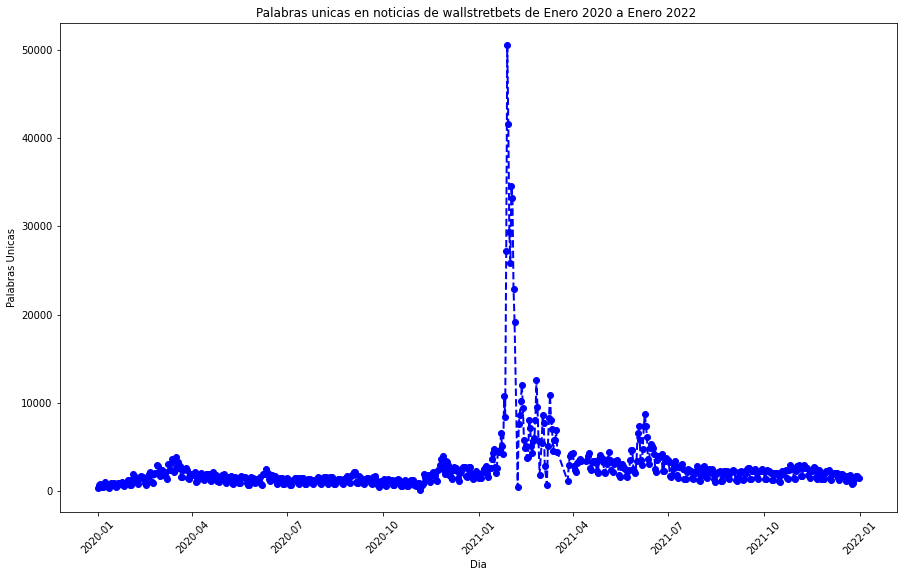

In [41]:
y = df_unique_words['Publish Date'].unique()
x = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in y]
sub_date = df_unique_words['Title']
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.title("Palabras unicas en noticias de wallstretbets de Enero 2020 a Enero 2022 ")
plt.xlabel("Dia")
plt.xticks(rotation=45)
plt.ylabel("Palabras Unicas")
plt.plot_date(x,sub_date,c="blue",ls="--" ,lw=2)
plt.show()

In [11]:
a = np.array(data['Publish Date'].value_counts().sort_index())
b = np.array(df_unique_words['Title'])
c = pd.DataFrame(np.divide(a,b),columns=['Razon'])
razon_q = pd.concat([data_proc['Publish Date'],c], axis=1)
razon_q

,Publish Date,Razon
0,2020-01-01,0.295580
1,2020-01-02,0.317797
2,2020-01-03,0.381841
3,2020-01-04,0.279817
4,2020-01-05,0.277293
...,...,...
709,2021-12-27,0.395968
710,2021-12-28,0.381344
711,2021-12-29,0.380952
712,2021-12-30,0.396170


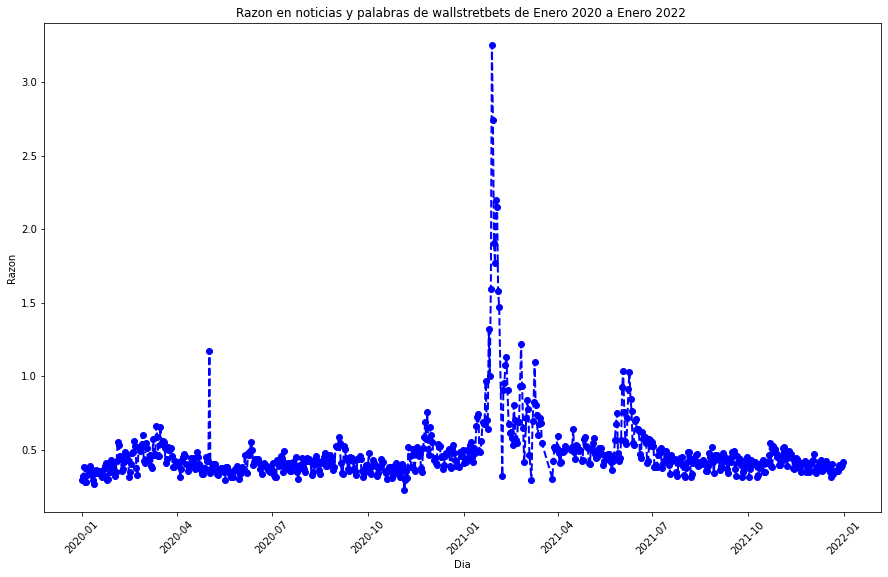

In [72]:
y = razon_q['Publish Date'].unique()
x = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in y]
sub_date = razon_q['Razon']
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.title("Razon en noticias y palabras de wallstretbets de Enero 2020 a Enero 2022 ")
plt.xlabel("Dia")
plt.xticks(rotation=45)
plt.ylabel("Razon")
plt.plot_date(x,sub_date,c="blue",ls="--" ,lw=2)
plt.show()

In [14]:
print("Dias que no se puede realizar PCA: ",razon_q.apply(lambda x: x['Razon']>=1, axis=1).sum())

Dias que no se puede realizar PCA:  18


In [67]:
serie_precio = data_y[["Date","Close"]]

sub_date = data['Publish Date'].value_counts().sort_index()
sub_date = pd.DataFrame(sub_date)
sub_date

file_txt = (location+"serie_precio.csv")
serie_precio.to_csv(file_txt)

file_txt = (location+"serie_volumen.csv")
sub_date.to_csv(file_txt)

In [35]:
!apt-get install r-base
!pip install rpy2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.0-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [40]:
%load_ext rpy2.ipython  

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%R -i sub_date
%R -i serie_precio

In [ ]:
%%R
install.packages('biwavelet')
library(biwavelet) 


In [66]:
%%R 
A = as.data.frame(cbind(serie_precio$Date,serie_precio$Close))
B = as.data.frame(cbind(serie_precio$Date,sub_date$'Publish Date'))
length(A)
A
#wtc(A,B,nrands=200)

            V1               V2
1   2020-01-02 6.30999994277954
2   2020-01-03 5.88000011444092
3   2020-01-06 5.84999990463257
4   2020-01-07 5.51999998092651
5   2020-01-08 5.71999979019165
6   2020-01-09 5.55000019073486
7   2020-01-10 5.42999982833862
8   2020-01-13 5.42999982833862
9   2020-01-14 4.71000003814697
10  2020-01-15  4.6100001335144
11  2020-01-16 4.61999988555908
12  2020-01-17             4.75
13  2020-01-21 4.59000015258789
14  2020-01-22 4.55999994277954
15  2020-01-23 4.61999988555908
16  2020-01-24 4.32000017166138
17  2020-01-27 4.28000020980835
18  2020-01-28 4.21000003814697
19  2020-01-29 4.13000011444092
20  2020-01-30  3.9300000667572
21  2020-01-31 3.83999991416931
22  2020-02-03 3.95000004768372
23  2020-02-04 4.07000017166138
24  2020-02-05 4.17999982833862
25  2020-02-06  4.1399998664856
26  2020-02-07 3.80999994277954
27  2020-02-10 3.94000005722046
28  2020-02-11 4.01999998092651
29  2020-02-12 4.19000005722046
30  2020-02-13  4.1100001335144
31  2020

In [49]:
serie_precio

,Date,Close
0,2020-01-02,6.310000
1,2020-01-03,5.880000
2,2020-01-06,5.850000
3,2020-01-07,5.520000
4,2020-01-08,5.720000
...,...,...
500,2021-12-27,148.309998
501,2021-12-28,146.460007
502,2021-12-29,153.929993
503,2021-12-30,155.330002


In [13]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
data_title = data['Title'].apply(lambda x:str(x).split())
stop_words = set(stopwords.words('english'))
stop_words.add('-')
data_title = [w for w in data_title if not w in stop_words]
top = Counter([item for sublist in data_title for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TypeError: ignored

In [22]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Palabras comunes en el texto', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

NameError: ignored

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import warnings
warnings.simplefilter("ignore")

def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "fuck", "fucking"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

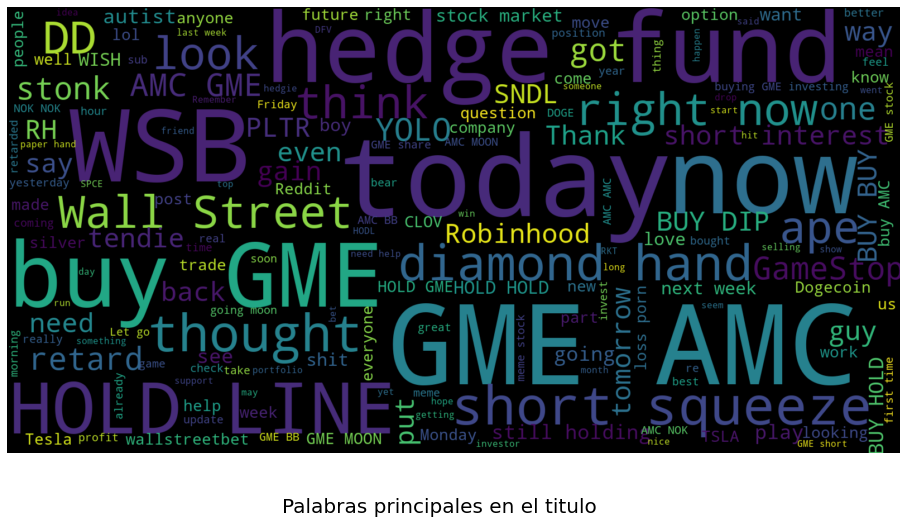

In [ ]:
show_wordcloud(data['Title'], title = 'Palabras principales en el titulo')

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"     

In [ ]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='green')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Contador : {title} sentimientos', size=12)
    ax2.set_ylabel(f'Porcentaje : {title} sentimientos', size=12)
    plt.suptitle(f"Analisis de sentimiento: {title}")
    plt.tight_layout()
    plt.show()

In [ ]:
data['title_sentiment'] = data['Title'].apply(lambda x: find_sentiment(x))
plot_sentiment(data, 'title_sentiment', 'Titulo')

In [ ]:
show_wordcloud(data.loc[data['title_sentiment']=='Positive', 'Title'], title = 'Palabras principales en titulos (Sentimiento positivo)')

In [ ]:
show_wordcloud(data.loc[data['title_sentiment']=='Negative', 'Title'], title = 'Palabras principales en titulos (Sentimiento negativo)')